Components to reach 80 % variance: 5


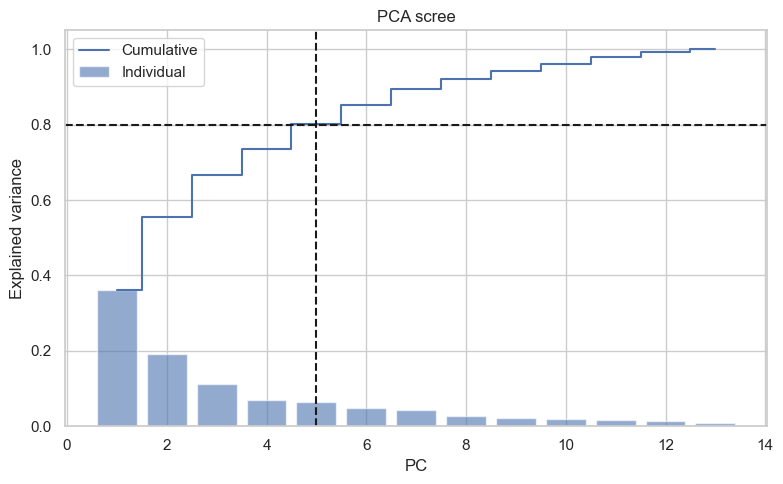

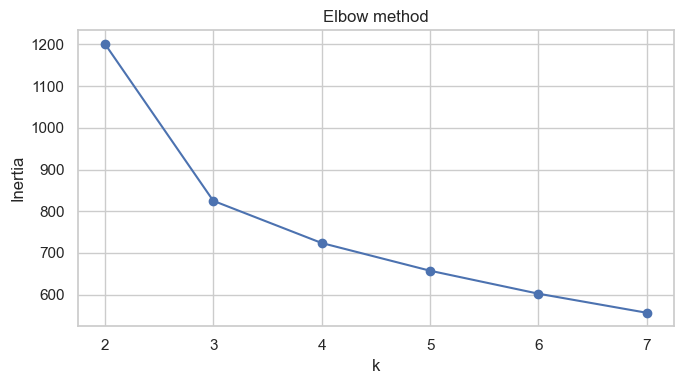

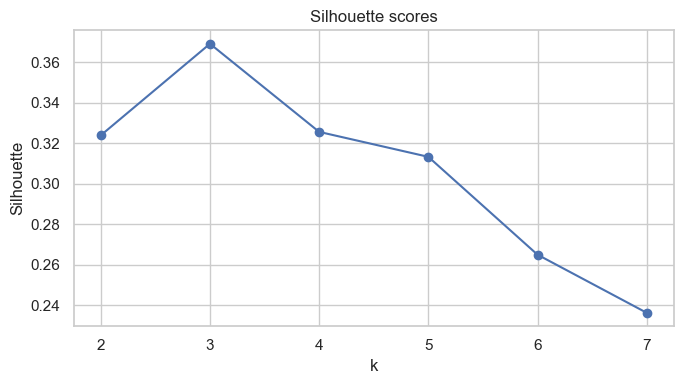

Best k by silhouette ≈ 3


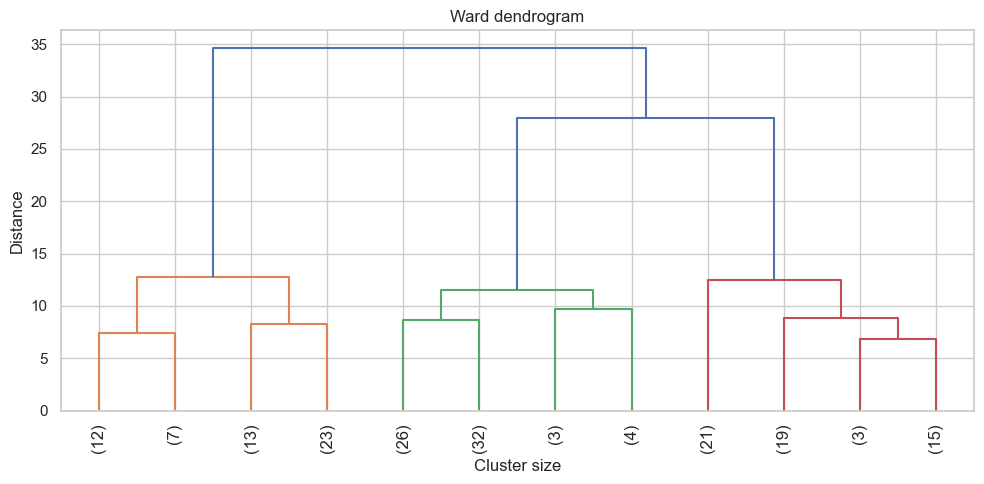

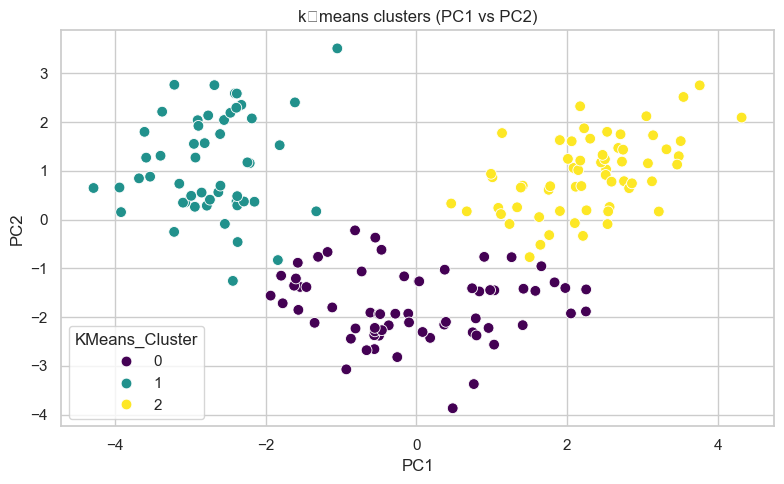

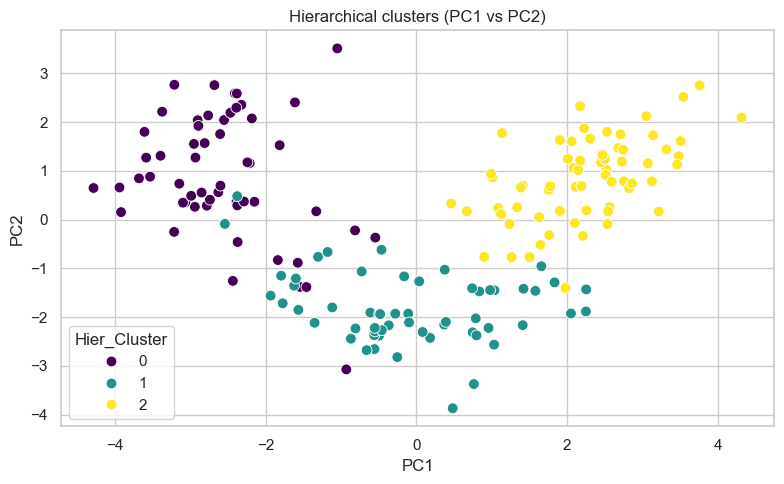


Cluster counts (k‑means):
KMeans_Cluster
0    65
2    62
1    51
Name: count, dtype: int64

Cluster counts (hierarchical):
Hier_Cluster
2    65
1    58
0    55
Name: count, dtype: int64


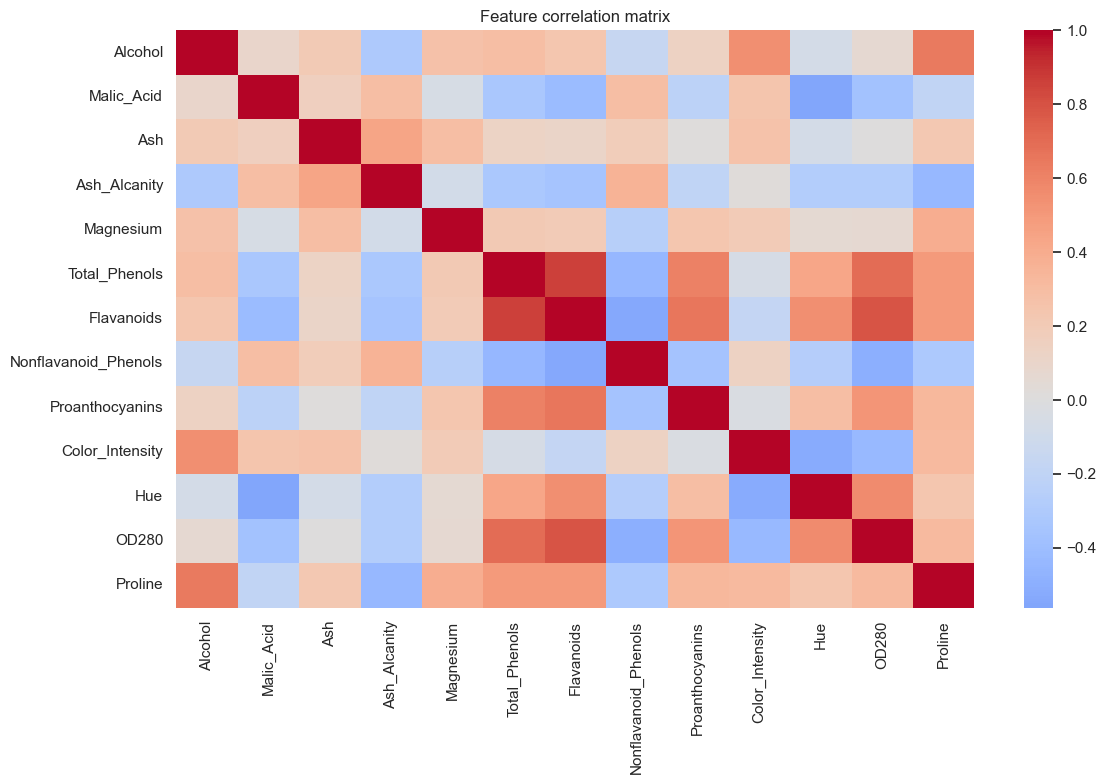


PCA loadings:
                        PC1    PC2    PC3    PC4    PC5
Alcohol               0.144  0.484 -0.207 -0.018 -0.266
Malic_Acid           -0.245  0.225  0.089  0.537  0.035
Ash                  -0.002  0.316  0.626 -0.214 -0.143
Ash_Alcanity         -0.239 -0.011  0.612  0.061  0.066
Magnesium             0.142  0.300  0.131 -0.352  0.727
Total_Phenols         0.395  0.065  0.146  0.198 -0.149
Flavanoids            0.423 -0.003  0.151  0.152 -0.109
Nonflavanoid_Phenols -0.299  0.029  0.170 -0.203 -0.501
Proanthocyanins       0.313  0.039  0.149  0.399  0.137
Color_Intensity      -0.089  0.530 -0.137  0.066 -0.076
Hue                   0.297 -0.279  0.085 -0.428 -0.174
OD280                 0.376 -0.164  0.166  0.184 -0.101
Proline               0.287  0.365 -0.127 -0.232 -0.158


In [3]:
# DDS8555-Assignment 7:  Min Lim wine clustering from kaggle
# Min Jeong Lim
# 4/20/2025
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set(style="whitegrid")  

df = pd.read_csv("wine-clustering.csv")     
X_scaled = StandardScaler().fit_transform(df)

# PCA – keep ≥80 % variance 
pca_full      = PCA(random_state=42).fit(X_scaled)
cum_var       = np.cumsum(pca_full.explained_variance_ratio_)
n_components  = np.argmax(cum_var >= 0.80) + 1
print(f"Components to reach 80 % variance: {n_components}")

# Scree plot
plt.figure(figsize=(8,5))
plt.bar(range(1,len(pca_full.explained_variance_ratio_)+1),
        pca_full.explained_variance_ratio_, alpha=0.6, label='Individual')
plt.step(range(1,len(cum_var)+1), cum_var, where='mid', label='Cumulative')
plt.axhline(0.80, ls='--', c='k'); plt.axvline(n_components, ls='--', c='k')
plt.xlabel('PC'); plt.ylabel('Explained variance'); plt.title('PCA scree')
plt.legend(); plt.tight_layout(); plt.show()

pca = PCA(n_components=n_components, random_state=42)
PCs = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(PCs, columns=[f"PC{i+1}" for i in range(n_components)])

# k‑means
k_range = range(2, 8)
inertias, sils = [], []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=25, random_state=42).fit(pca_df)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(pca_df, km.labels_))

# elbow curve
plt.figure(figsize=(7,4))
plt.plot(k_range, inertias, marker='o'); plt.xlabel("k"); plt.ylabel("Inertia")
plt.title("Elbow method"); plt.tight_layout(); plt.show()

# silhouette scores
plt.figure(figsize=(7,4))
plt.plot(k_range, sils, marker='o'); plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Silhouette scores"); plt.tight_layout(); plt.show()

best_k = k_range[int(np.argmax(sils))]
print(f"Best k by silhouette ≈ {best_k}")

km_best = KMeans(n_clusters=best_k, n_init=25, random_state=42).fit(pca_df)
pca_df["KMeans_Cluster"] = km_best.labels_

# Hierarchical clustering 
Z = linkage(pca_df.iloc[:, :n_components], method='ward')
plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90)
plt.title("Ward dendrogram"); plt.xlabel("Cluster size"); plt.ylabel("Distance")
plt.tight_layout(); plt.show()

agg = AgglomerativeClustering(n_clusters=best_k,
                              metric='euclidean', linkage='ward')
pca_df["Hier_Cluster"] = agg.fit_predict(pca_df.iloc[:, :n_components])

# Cluster scatter (first two PCs) 
plt.figure(figsize=(8,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="KMeans_Cluster",
                palette="viridis", s=60)
plt.title("k‑means clusters (PC1 vs PC2)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Hier_Cluster",
                palette="viridis", s=60)
plt.title("Hierarchical clusters (PC1 vs PC2)"); plt.tight_layout(); plt.show()

# Quick comparisons + diagnostics
print("\nCluster counts (k‑means):")
print(pca_df["KMeans_Cluster"].value_counts())
print("\nCluster counts (hierarchical):")
print(pca_df["Hier_Cluster"].value_counts())

# correlation heat‑map
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(X_scaled, columns=df.columns).corr(),
            cmap='coolwarm', center=0, annot=False)
plt.title("Feature correlation matrix"); plt.tight_layout(); plt.show()

# PCA loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f"PC{i+1}" for i in range(n_components)],
                        index=df.columns)
print("\nPCA loadings:")
print(loadings.round(3))
